In [1]:
from ipyleaflet import Map, DrawControl
import numpy as np

# Ausgabe der Bounding Box der letzten gezeichneten Geometrie
def get_bounding_box():
    drawn_coordinates = draw_control.data[0]['geometry']['coordinates']

    min_lat = None
    max_lat = None

    min_lon = None
    max_lon = None

    for coords in drawn_coordinates[0]:
        if max_lat is None:
            max_lat =  min_lat = np.round(coords[1], 2)
            max_lon =  min_lon = np.round(coords[0], 2)

        elif coords[1] < min_lat:
            min_lat = np.round(coords[1], 2)

        elif coords[1] > max_lat:
            max_lat = np.round(coords[1], 2)

        elif coords[0] < min_lon:
            min_lon = np.round(coords[0], 2)

        elif coords[0] > max_lon:
            max_lon = np.round(coords[0], 2)

    return [min_lat, max_lat], [min_lon, max_lon]


m = Map(center=(50, 3), zoom=2)

draw_control = DrawControl()

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m

Map(center=[50, 3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [2]:
draw_control.data

[{'type': 'Feature',
  'properties': {'style': {'stroke': True,
    'color': '#fca45d',
    'weight': 4,
    'opacity': 0.5,
    'fill': True,
    'fillColor': '#fca45d',
    'fillOpacity': 1,
    'clickable': True}},
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-2.802275, 16.60461],
     [-2.802275, 30.420256],
     [14.778093, 30.420256],
     [14.778093, 16.60461],
     [-2.802275, 16.60461]]]}}]

In [3]:
try:
    LAT_BOUNDING_BOX, LON_BOUNDING_BOX = get_bounding_box()
    print(LAT_BOUNDING_BOX)
    print(LON_BOUNDING_BOX)

except IndexError:
    print("Bitte Area of Interest in Karte einzeichnen!")



[16.6, 30.42]
[-2.8, 14.78]


## Verarbeitung der GPM-IMERG HDF5 Dateien

- Entpacken der HDF5 Dateien
- Extraktion des AOI (Bounding Box)
- Umrechnung mm / h in mm / Monat
- Berechnung des langjährigen Maximums je Zelle (0.1° x 0.1°)
- Bestimmung der Monate mit größter NS-Anomalie (Durchschnitt aller Zellen im AOI)
- Sortieren der Minima nach Zeit, Bestimmung der Zeitspanne zwischen den Minima
- Ausgabe des letzten Monats der längsten zusammenhängenden Zeitspanne

In [4]:
import os

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

from datetime import datetime as dt

import xarray as xr
import calendar

# Umrechnen des Monatsdurchschnitts von mm / hr in Monatssumme mm / month:
def accumulate_precip(data, timestamp):
    real_timestamp = dt.utcfromtimestamp(timestamp).strftime('%Y-%m-%d').split("-")

    # mm / d:
    data = data * 24

    # mm / month: Fallunterscheidung nötig für unterschiedlich lange Monate & Schaltjahre
    if real_timestamp[1] in ["01", "03", "05", "07", "08", "10", "12"]:
        data *= 31
        print("long month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp[1] == "02" and calendar.isleap(int(real_timestamp[0])):
        data *= 29
        print("short month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp == "02" and not calendar.isleap(int(real_timestamp[0])):
        data *= 28
        print("very short month") # min:  ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    else:
        data *= 30
        print("medium month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))
    
    return data


# Liest Werte des AOI aus HDF5-Datei aus und gibt ein xarray monatlich akkumulierter Werte zurück
def xr_aoi(FILE_NAME, LAT_RANGE, LON_RANGE):
        
    with h5py.File(FILE_NAME, mode='r') as f:
        # Group-Name & Variable im HDF5-File  
        name = '/Grid/precipitation'

        # Zeitstempel vom ersten Tag des Monats in Unix-Zeit
        unix_timestamp = f['Grid/time'][0]
        # Umrechnung in UTC-Zeit
        utc_timestamp = dt.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d')    

        # Einlesen der Niederschlagsdaten: gegeben in mm / hr
        data = f[name][0,:,:]

        # Einlesen des Füllwertes aus den Attributen
        _FillValue = f[name].attrs['_FillValue']

        # Ersetzen des Füllwertes durch nan
        data[data == _FillValue] = np.nan
        
        # Umrechnen von mm / hr in Monatssumme
        data = accumulate_precip(data, unix_timestamp)

        #units = f[name].attrs['units']

        # Einlesen der Breitenkoordinaten
        lat = f['Grid/lat'][ : ]
        #print(lat)

        # Einlesen der Längenkoordinaten
        lon = f['Grid/lon'][ : ]
        #print(lon)

        # Zuweisung von Koordinatenskalen für neues xarray
        coords =  {
            'lon': lon,
            'lat': lat,  
            'time': dt.utcfromtimestamp(unix_timestamp)
            }
        
        # Definition von zusätzlichen Attributen
        attrs = {
            'fill_value': _FillValue
        }

        # Anlegen des xarrays mit allen NS-Daten und obigen Definitionen
        da = xr.DataArray(
            data, 
            coords=coords, 
            dims=['lon', 'lat'],
            attrs=attrs
            )
        #print(da)

        # Extraktion der Werte für AOI
        da_sel = da.sel({
                'lon': LON_RANGE,
                'lat': LAT_RANGE                
                },
                method='nearest',
                tolerance=0.09
                )
        
        print(da_sel.coords)
        print("min: ", np.nanmin(da_sel.values), ", max: ", np.nanmax(da_sel.values), ", mean: ", np.nanmean(da_sel.values))

        return da_sel

# Plottet die Werte eines xarrays
def plot_aoi(data, title_str="DEFAULT TITLE", axis_label="DEFAULT LABEL"):
    # Es soll ein Rahmen um das AOI von 8° in alle Richtungen geplottet werden
    try:
        m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]-8), urcrnrlat=(LAT_BOUNDING[1]+8),
                llcrnrlon=(LON_BOUNDING[0]-8), urcrnrlon=(LON_BOUNDING[1]+8)
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    # Liegt einer der Werte außerhalb des Werteraums [-90;90] bzw. [-180;180] wird kein Rahmen geplottet
    except ValueError:
                m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]), urcrnrlat=(LAT_BOUNDING[1]),
                llcrnrlon=(LON_BOUNDING[0]), urcrnrlon=(LON_BOUNDING[1])
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.2)
    m.drawparallels(np.arange(
        (LAT_BOUNDING[0]) - 15, 
        (LAT_BOUNDING[1] + 15), 
        ( (LAT_BOUNDING[1] - LAT_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.drawmeridians(
        np.arange(
        (LON_BOUNDING[0]) - 15, 
        (LON_BOUNDING[1] + 15), 
        ( (LON_BOUNDING[1] - LON_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.pcolormesh(
        LON_RANGE,
        LAT_RANGE,
        data.T,
        latlon=True
        )
    cb = m.colorbar()    
    cb.set_label(axis_label)

    plt.title(f'{title_str} {str(data.time.values)[0:7]}') # Abschneiden des restlichen Zeitstempels
 


KeyError: 'PROJ_LIB'

In [1]:
DATA_PATH = '../data/GPM_Data_2000_2021'
#DATA_PATH = './data/GPM_Data_Small'

LAT_BOUNDING = sorted(LAT_BOUNDING_BOX)
LON_BOUNDING = sorted(LON_BOUNDING_BOX)

# Anlegen von Arrays mit Größe der Bounding Box & passender Auflösung
LAT_RANGE = np.arange(LAT_BOUNDING[0], LAT_BOUNDING[1], 0.1)
LON_RANGE = np.arange(LON_BOUNDING[0], LON_BOUNDING[1], 0.1)

# Liste um die xarray-Monatsniederschläge temporär zu speichern
data_array_list = []

# Sortieren der Dateinamen: alt nach neu
filepaths = sorted(os.listdir(DATA_PATH))


for filename in filepaths:
    # Überspringe alle nicht-HDF5 Dateien
    if filename[-4:] != 'HDF5': 
        print(f'Unpassendes Dateiformat:\n"{filename}"\nUeberspringe Datei')
        continue

    # Zusammmensetzen von Speicherpfad und Dateiname
    path_file = os.sep.join([DATA_PATH, filename])

    # Anfügen der akkumulierten Monatsniederschläge für das AOI an temporäre Liste
    data_array_list.append(xr_aoi(path_file, LAT_RANGE, LON_RANGE))

# Stack der Monatsniederschläge entlang der Zeitachse für eine Zeitreihe
xr_data_stack = xr.concat(data_array_list, 'time' )


NameError: name 'LAT_BOUNDING_BOX' is not defined

In [55]:
# Gruppieren der Monate 1-12 --> Index startet bei 1!
grouped_stacks = xr_data_stack.groupby(xr_data_stack.time.dt.month) 
#grouped_stacks[6][-1] # letztes Jahr des Monats Juni

In [56]:
# 2D Liste für xarrays mit den Zellwerten des Percent of Normal Index (PNI)
percent_of_average_precip_stack = [ [] for _ in range(12) ]

# Iteriere über die stacks der 12 Monate
for i, month in enumerate(grouped_stacks):

    # "month" als Teil des groupedby-Objekts "grouped_stacks" ist ein Tupel, 
    # xarray ist an Stelle 1, 
    # Durchschnitt entlang der Zeitachse, 
    # "skipna" überspringt nan-Werte
    average_over_time = month[1].mean(dim="time", skipna=True)

    # Iteriere über die Jahrgänge innerhalb der verschiedenen Monate 
    # und berechne jeweils die Höhe gemessen am langjährigen Mittel
    for j, month_of_year in enumerate(month[1]):
        percent_of_average_precip_stack[i].append((month_of_year / average_over_time ) * 100) # = PNI je Zelle!


# Iteriere über die 12 Monate, "stack" jeweils als Liste von xarrays der Jahrgänge mit den Zellwerten des PNI
for i, stack in enumerate(percent_of_average_precip_stack):
    print("Monat ", i+1)
    print(stack)


Monat  1
[<xarray.DataArray (lon: 110, lat: 123)>
array([[ 96.75549 ,  57.886654,  53.238464, ..., 101.09069 , 100.74135 ,
        100.25586 ],
       [ 95.385864,  65.695496,  56.138466, ...,  98.40418 ,  97.77016 ,
         98.595695],
       [ 72.773575,  76.2782  ,  55.00995 , ...,  95.41366 ,  95.902504,
         95.420494],
       ...,
       [115.64516 , 118.05314 , 130.01343 , ..., 310.2534  , 294.94867 ,
        280.34238 ],
       [115.64516 , 118.05314 , 130.01343 , ..., 310.2534  , 294.94867 ,
        280.34238 ],
       [118.60516 , 121.07555 , 138.55435 , ..., 322.13116 , 309.58466 ,
        298.16373 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 102.3 102.4 102.6 102.6 ... 112.9 113.1 113.1 113.2
  * lat      (lat) float32 22.55 22.65 22.75 22.85 ... 34.45 34.55 34.65 34.75
    time     datetime64[ns] 2001-01-01, <xarray.DataArray (lon: 110, lat: 123)>
array([[141.59618 , 147.87383 , 144.95619 , ..., 102.81211 , 104.03833 ,
        103.235245],
       [146.1

In [57]:
# Summe der Prozente = 0
sum_percts = 0

# Iteriere über den Stack der % monatlichen Durchschnitts-NS für Januar ( idx = 0)
# und summiere über die 21 Jahre auf
for i, stack in enumerate(percent_of_average_precip_stack[0]):
    # Ausgabe des Durchschnitts aller Zellen EINES Jahres im AOI
    print( np.datetime_as_string(stack.time, 'M' ), ": ", np.nanmean(stack))
    sum_percts += np.nanmean(stack)

# Der Durchschnitt ergibt wiederum 100: passt!
print("Durchschnitt = 100?: ", sum_percts / 21)

# Mit folgender Abfrage ist es nun möglich auf das Minimum der Monate Januar zuzugreifen 
# und an das entsprechende Datum zu gelangen
minimum_of_jan = min( [ stack.mean(skipna=True) for stack in percent_of_average_precip_stack[0] ])
print(minimum_of_jan, '\n', np.datetime_as_string(minimum_of_jan.time, 'M'))


2001-01 :  113.63985
2002-01 :  92.26292
2003-01 :  104.11991
2004-01 :  90.73626
2005-01 :  85.726234
2006-01 :  64.38993
2007-01 :  92.3219
2008-01 :  135.44437
2009-01 :  44.16785
2010-01 :  68.362526
2011-01 :  81.08067
2012-01 :  124.24641
2013-01 :  42.306614
2014-01 :  35.735115
2015-01 :  119.65898
2016-01 :  135.76575
2017-01 :  93.86746
2018-01 :  154.0434
2019-01 :  117.12311
2020-01 :  234.87213
2021-01 :  70.12858
Durchschnitt = 100?:  99.999997820173
<xarray.DataArray ()>
array(35.735115, dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-01-01 
 2014-01


In [58]:
# Kandidat für globales Minimum
minimum_candidate = None

# Liste möglicher Kandidaten: mehrere Monate in Folge? Dann Favorit!
candidates_list = []

# Iteriere über alle Monate des PNI
for month in percent_of_average_precip_stack:
    # Setzen des ersten Kandidaten im ersten Durchlauf
    if minimum_candidate is None:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])

    # Prüfe für alle folgenden Durchläufe ob Wert unter bisherigem Kandidaten,  
    # falls ja: Update des Kandidaten
    elif min( [ stack.mean(skipna=True) for stack in month ]) < minimum_candidate:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])
    
    # Das Minimum des jeweiligen Monts wird der Liste angehängt
    candidates_list.append(min( [ stack.mean(skipna=True) for stack in month ]))

    print(min( [ stack.mean(skipna=True) for stack in month ]))

# Ausgabe des globalen Minimums
print("Globales Minimum: ", np.datetime_as_string(minimum_candidate.time, 'M'), '\n', minimum_candidate)

<xarray.DataArray ()>
array(35.735115, dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-01-01
<xarray.DataArray ()>
array(43.00397, dtype=float32)
Coordinates:
    time     datetime64[ns] 2010-02-01
<xarray.DataArray ()>
array(67.986626, dtype=float32)
Coordinates:
    time     datetime64[ns] 2006-03-01
<xarray.DataArray ()>
array(48.05691, dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-04-01
<xarray.DataArray ()>
array(82.532745, dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-05-01
<xarray.DataArray ()>
array(82.932465, dtype=float32)
Coordinates:
    time     datetime64[ns] 2006-06-01
<xarray.DataArray ()>
array(67.83974, dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-07-01
<xarray.DataArray ()>
array(65.57336, dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-08-01
<xarray.DataArray ()>
array(58.280815, dtype=float32)
Coordinates:
    time     datetime64[ns] 2002-09-01
<xarray.DataArray ()>
array(40.21399, dtype=float3

In [65]:
candidates_list = sorted(candidates_list, key=lambda x: x.time)
candidates_list

[<xarray.DataArray ()>
 array(58.280815, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2002-09-01,
 <xarray.DataArray ()>
 array(40.21399, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2004-10-01,
 <xarray.DataArray ()>
 array(67.986626, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2006-03-01,
 <xarray.DataArray ()>
 array(82.932465, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2006-06-01,
 <xarray.DataArray ()>
 array(42.800877, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2007-11-01,
 <xarray.DataArray ()>
 array(43.00397, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2010-02-01,
 <xarray.DataArray ()>
 array(48.05691, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2011-04-01,
 <xarray.DataArray ()>
 array(67.83974, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2011-07-01,
 <xarray.DataArray ()>
 array(65.57336, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2011-08-01,
 <xarr

In [66]:
# Iteriere über die nach Datum sortierten Maxima, 
# folgen zwei dieser Monate aufeinander wird dies durch einen höheren Wert im Dict vermerkt, 
# Bei einer Lücke wird der Zähler auf 0 zurück gesetzt
dry_spells = dict()
dry_spell_length = 0

candidates_list

for i, candidate in enumerate(candidates_list):
    if i >= len(candidates_list)-1 :
        break
    print(candidates_list[i].time.values, " bis ", candidates_list[i+1].time.values, ":")
    print(
        (
            candidates_list[i+1].time.values -
            candidates_list[i].time.values
        ).astype('timedelta64[D]')
    )

    if (candidates_list[i+1].time.values -
        candidates_list[i].time.values).astype('timedelta64[D]') <= np.timedelta64(31, 'D'):
        dry_spell_length += 1
        dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length
    
    else:
        dry_spell_length = 0
        dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length


dry_spells


2002-09-01T00:00:00.000000000  bis  2004-10-01T00:00:00.000000000 :
761 days
2004-10-01T00:00:00.000000000  bis  2006-03-01T00:00:00.000000000 :
516 days
2006-03-01T00:00:00.000000000  bis  2006-06-01T00:00:00.000000000 :
92 days
2006-06-01T00:00:00.000000000  bis  2007-11-01T00:00:00.000000000 :
518 days
2007-11-01T00:00:00.000000000  bis  2010-02-01T00:00:00.000000000 :
823 days
2010-02-01T00:00:00.000000000  bis  2011-04-01T00:00:00.000000000 :
424 days
2011-04-01T00:00:00.000000000  bis  2011-07-01T00:00:00.000000000 :
91 days
2011-07-01T00:00:00.000000000  bis  2011-08-01T00:00:00.000000000 :
31 days
2011-08-01T00:00:00.000000000  bis  2014-01-01T00:00:00.000000000 :
884 days
2014-01-01T00:00:00.000000000  bis  2014-05-01T00:00:00.000000000 :
120 days
2014-05-01T00:00:00.000000000  bis  2017-12-01T00:00:00.000000000 :
1310 days


{'2004-10-01T00:00:00.000000000': 0,
 '2006-03-01T00:00:00.000000000': 0,
 '2006-06-01T00:00:00.000000000': 0,
 '2007-11-01T00:00:00.000000000': 0,
 '2010-02-01T00:00:00.000000000': 0,
 '2011-04-01T00:00:00.000000000': 0,
 '2011-07-01T00:00:00.000000000': 0,
 '2011-08-01T00:00:00.000000000': 1,
 '2014-01-01T00:00:00.000000000': 0,
 '2014-05-01T00:00:00.000000000': 0,
 '2017-12-01T00:00:00.000000000': 0}

In [72]:
# Falls es keine Abfolge von mindestens 2 Minima mit einem Abstand von 31 Tagen gibt, 
# Prüfe ob es eine Abfolge mit einem Abstand von maximal 62 Tagen gibt
if max(dry_spells.values()) == 0:
    for i, candidate in enumerate(candidates_list):
        if i >= len(candidates_list)-1 :
            break
        print(candidates_list[i].time.values, " bis ", candidates_list[i+1].time.values, ":")
        print(
            (
                candidates_list[i+1].time.values -
                candidates_list[i].time.values
            ).astype('timedelta64[D]')
        )

        if (candidates_list[i+1].time.values -
            candidates_list[i].time.values).astype('timedelta64[D]') <= np.timedelta64(62, 'D'):
            dry_spell_length += 1
            dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length
        
        else:
            dry_spell_length = 0
            dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length


    dry_spells

else:
    print("Zeitspanne im Abstand von 31 Tagen gefunden.")


Zeitspanne im Abstand von 31 Tagen gefunden.


In [75]:
# Falls es eine Abfolge mehrerer trockener Monate gibt, Ausgabe des letzten Monats davon
if max( dry_spells.values() ) != 0:
    # Ausgabe des Keys bzw. Monats mit dem höchsten Value, 
    # Bei gleichen Werten wird der neuere ausgegeben (reversed(dict))
    print("Mehrmonatige Zeitspanne gefunden. Letzter Monat:")
    maximum_dry_spell = max(reversed(dry_spells), key=dry_spells.get).astype('datetime64[ns]')

# Falls keine Abfolge vorhanden, Ausgabe des globalen Minimum
else:
    maximum_dry_spell = minimum_candidate.time.values
    print("Keine Zeitspanne gefunden. Globales Minimum:")

maximum_dry_spell

Mehrmonatige Zeitspanne gefunden. Letzter Monat:


numpy.datetime64('2011-08-01T00:00:00.000000000')

<xarray.DataArray (lon: 110, lat: 123)>
array([[ 96.75549 ,  57.886654,  53.238464, ..., 101.09069 , 100.74135 ,
        100.25586 ],
       [ 95.385864,  65.695496,  56.138466, ...,  98.40418 ,  97.77016 ,
         98.595695],
       [ 72.773575,  76.2782  ,  55.00995 , ...,  95.41366 ,  95.902504,
         95.420494],
       ...,
       [115.64516 , 118.05314 , 130.01343 , ..., 310.2534  , 294.94867 ,
        280.34238 ],
       [115.64516 , 118.05314 , 130.01343 , ..., 310.2534  , 294.94867 ,
        280.34238 ],
       [118.60516 , 121.07555 , 138.55435 , ..., 322.13116 , 309.58466 ,
        298.16373 ]], dtype=float32)
Coordinates:
  * lon      (lon) float32 102.3 102.4 102.6 102.6 ... 112.9 113.1 113.1 113.2
  * lat      (lat) float32 22.55 22.65 22.75 22.85 ... 34.45 34.55 34.65 34.75
    time     datetime64[ns] 2001-01-01
<xarray.DataArray (lon: 110, lat: 123)>
array([[141.59618 , 147.87383 , 144.95619 , ..., 102.81211 , 104.03833 ,
        103.235245],
       [146.15962 , 154.

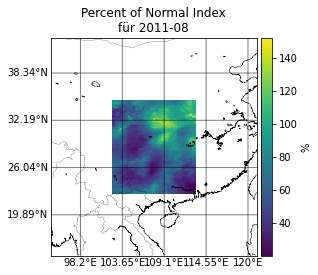

In [70]:
# temporäre Liste um geschachtelten percent_of_average_precip_stack in xarray zu überführen
temp_1d_list = []

for months in percent_of_average_precip_stack:
    for year in months:
        temp_1d_list.append(year)
        print(year)

# Verbinden entlang der Zeitachse
PNI_1d_stack = xr.concat(temp_1d_list, 'time' )

# Aus dem neuen xarray kann nun der ermittelte Minimalwert einfach abgefragt werden
global_minimum = PNI_1d_stack.sel(time= ( PNI_1d_stack.time == maximum_dry_spell ) )

plot_aoi(global_minimum[0], "Percent of Normal Index\nfür", "%") # idx 0 entspricht dem ersten (und einzigem) Zeitpunkt des xarrays

Text(0, 0.5, 'Häufigkeit')

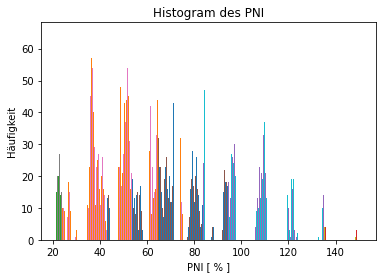

In [71]:
# Die Verteilung wird im Histogramm klarer
plt.hist( global_minimum[0] )
plt.title('Histogram des PNI')
plt.xlabel('PNI [ % ]')
plt.ylabel('Häufigkeit')